Machine learning Notebook
====
Partie I : Importation and dataframe creation
----
Partie II : Optimisation MACD
---
Partie III : Optimisation Bande de Bollinger
----

Partie I
====
1) Importations
----

In [1]:
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

In [2]:
file_name = 'btc_eur_3600.csv'
df_primary = pd.read_csv(r'C:\Users\flore\.spyder-py3\trading_bot\btc_eur_3600.csv', index_col='timestamp')

In [3]:
print(df_primary.head())
"df_primary = df_primary.drop('timestamp', axis = 1)"
#df_primary.describe()

                            date  length  low_price  high_price  \
timestamp                                                         
1504314000  2017-09-02T01:00:00Z    3600    4172.50     4185.00   
1504317600  2017-09-02T02:00:00Z    3600    4145.00     4185.00   
1504321200  2017-09-02T03:00:00Z    3600    4076.02     4163.37   
1504324800  2017-09-02T04:00:00Z    3600    4072.02     4106.23   
1504328400  2017-09-02T05:00:00Z    3600    3850.18     4094.02   

            opening_price  closing_price      volume      bdb_low  \
timestamp                                                           
1504314000        4172.75        4185.00    9.827998  4057.037771   
1504317600        4185.00        4153.04   15.091203  4067.629643   
1504321200        4154.73        4076.02   31.744749  4075.525587   
1504324800        4079.73        4094.01   14.755165  4078.846265   
1504328400        4094.01        3913.98  185.642850  4050.981341   

               bdb_high        mme12        mm

"df_primary = df_primary.drop('timestamp', axis = 1)"

2) Normalisation
----
Our stock prices are moving around the time, so to have a consistent dataframe we need to harmonize
our data. This way we can compare september's figures with march's figures.

In [4]:
from pandas.plotting import scatter_matrix
df_norm=df_primary.copy()

"normalization"

df_norm['bdb_high_n'] = df_norm['bdb_high'] / df_norm['opening_price']
df_norm['bdb_low_n'] = df_norm['bdb_low'] / df_norm['opening_price']
df_norm['high_price_n'] = df_norm['high_price'] / df_norm['opening_price']
df_norm['low_price_n'] = df_norm['low_price'] / df_norm['opening_price']
df_norm['mme12_n'] = df_norm['mme12'] / df_norm['opening_price']
df_norm['mme26_n'] = df_norm['mme26'] / df_norm['opening_price']
df_norm['macd_n'] = df_norm['macd'] / df_norm['opening_price']

#print(df_norm.head)

3) Quantitative columns
----
After our research in financial analysis, we have decided to add some columns to our dataframe to 
help us doing our predictions. Those columns are going to help us to see the trends. 
We are creating for most of our datas, derivate and second derivate.
We also create volatility as it could be a good indicator of a big prices variation.

In [5]:
df_init = df_norm.copy()

"on rajoute les variables construites a partir de celles ci dessus"

df_init['variation'] = (df_init['closing_price'] - df_init['opening_price']) / df_init['opening_price']*100
df_init['derivate_macd_n'] = df_init['macd_n'] - df_init['macd_n'].shift(1)
df_init['2nd_derivate_macd_n'] = df_init['macd_n'] + df_init['macd_n'].shift(2)
df_init['derivate_stochastic'] = df_init['stochastic'] - df_init['stochastic'].shift(1)
df_init['volatility'] = df_init['high_price_n'] - df_init['low_price_n']
df_init['derivate_volatility'] = df_init['volatility'] - df_init['volatility'].shift(1)
df_init['derivate_volume'] = df_init['volume'] - df_init['volume'].shift(1)

#print(df_init.head())

4) Clear dataframe
----
Now that we have created all our columbs to do our project, we need to get rid of all the data that
are not useful anymore : all the one that our not normalized.

In [6]:
df_drop = df_init.copy()

df_drop = df_drop.drop('closing_price', axis = 1)
df_drop = df_drop.drop('bdb_low', axis = 1)
df_drop = df_drop.drop('bdb_high', axis = 1)
df_drop = df_drop.drop('mme12', axis = 1)
df_drop = df_drop.drop('mme26', axis = 1)
df_drop = df_drop.drop('opening_price', axis = 1)
df_drop = df_drop.drop('low_price', axis = 1)
df_drop = df_drop.drop('high_price', axis = 1)
df_drop = df_drop.drop('length', axis = 1)
df_drop = df_drop.drop('date', axis = 1)
df_drop = df_drop.drop('macd', axis = 1) 

#print(df_drop.head())

5) Synchronization
----
When we will do our study, we will have as the function entrance the vector with the datas from t-1,
and with those value we want to be able to predict our time t. 
To this end we are going to move all our columns of one unity except the one that we want to predict 
which is the variation one.

In [41]:
df_shift = df_drop.copy()

df_shift['variation'] = df_shift['variation'].shift(-1)

"we are dropping our Nan value"
df_shift.dropna(inplace=True)
#print(df_shift.head())

Partie 2 : Optimisation MACD
====
1) Vector creation
----
During this step, we want to help our model to understand MACD properly. This way we are creating a
strategy quiet logic. We have three if layers. 
The most important one is about the MACD sign (+ ou -).
The second one is about the MACD derivate sign (+ ou -).
And the third one is about the MACD second derivate sign (+ ou -).

In [175]:

def  macd_perso(df, shift = 0, seuil_a = -0.0092, seuil_b =0.0021, seuil_c = 0.014, seuil_d = 0):
    
    macd = df['macd_n'].values.tolist()
    derivate_macd = df['derivate_macd_n'].values.tolist()
    second_derivate_macd = df['2nd_derivate_macd_n'].values.tolist()
    macd_action = []
    
    for i in range(len(derivate_macd)):
        
        if macd[i] >= seuil_a:
            
            if derivate_macd[i] <= seuil_b:
                
                if second_derivate_macd[i] <= seuil_d:
                    macd_action.append(-1)
                else:
                    macd_action.append(0)
                    
            elif derivate_macd[i] > seuil_b:
                
                if second_derivate_macd[i] <= seuil_c:
                    macd_action.append(0)
                else:
                    macd_action.append(1)
                
        elif macd[i] < seuil_a:
            
            if derivate_macd[i] <= 0:
                
                if second_derivate_macd[i] <= 0:
                    macd_action.append(-1)
                else:
                    macd_action.append(-1)
                              
            elif derivate_macd[i] > 0:
                
                if second_derivate_macd[i] <= 0:
                    macd_action.append(-1)
                else:
                    macd_action.append(-1)

    array_macd = np.asarray(macd_action)
    df_macd_perso = pd.DataFrame(array_macd,columns = ['macd_action_a'])
    df_variation = df['variation'].values.tolist()
    array_variation = np.asarray(df_variation)
    df_variation = pd.DataFrame(array_variation,columns = ['variation'])
    df_return=pd.concat([df_macd_perso, df_variation], axis=1)
    df_return['macd_action']=df_return['macd_action_a'].shift(shift)
    #df_return.dropna(inplace = True)
    return(df_return)
#return(macd_action)

In [176]:
def gain_uiui(decisions_list, market_prices, fee_rate = 0.3):
    """
    Returns the list of successive gains.
    Prints other info like number of hold, buy, sell, free_cash, fee costs.
    """
    return

def make_decisions(strategy, data):
    """
    Returns a list made of 0 for hold, 1 for buy, -1 for sell.
    """
    decisions.append()
    return 

2) Gain function creation
----
Now we want to test with some simple rules our MACD vector.

In [177]:

def  Gain_hypothetique(predictions, variation, commission = 0.3):

    cash = True
    gain_pourcent = [100]
    liste_variation = [100]
    chandelier_achat = [100]
    chandelier_vente = [100]
    gain_hold = [100]
    depenses_commission = [100]
    free_cash = 0
    achat = 0
    vente = 0
    hold = 0
    

    for i in range(len(variation)):
        
        liste_variation.append(liste_variation[-1] * (100 + variation[i]) / 100)


        if predictions[i] == 1 and cash:
            cash = False
            gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i] - commission) / 100)
            depenses_commission.append(depenses_commission[-1] + gain_pourcent[-1] * commission / 100)
            achat += 1
            
        elif predictions[i] == -1 and cash:
            gain_pourcent.append(gain_pourcent[-1])
            free_cash += 1
            
        elif predictions[i] == 0 and cash:
            gain_pourcent.append(gain_pourcent[-1])
            free_cash += 1
            
        elif predictions[i] == 0 and not cash:
            gain_pourcent.append(gain_pourcent[-1] * (100 + variation[i]) / 100)
            hold += 1
            
            
        elif predictions[i] == -1 and not cash:
            cash = True
            gain_pourcent.append(gain_pourcent[-1] * (100 - commission) / 100)
            depenses_commission.append(depenses_commission[-1] + gain_pourcent[-1] * commission / 100)
            vente += 1

        elif predictions[i] == 1 and not cash:
            gain_pourcent.append(gain_pourcent[-1] * (100 + variation[i]) / 100)
            hold += 1




        
        else:
            continue
    
    return(gain_pourcent, liste_variation, hold, achat, vente, free_cash, depenses_commission)

3) Visualisation
----
After all those functions this is now that we are going to visualize our results.

Shifting : Quand on regarde un graphique de la MACD on peut voir qu'il y a une périodicité si on est vraiment attentitf

Variation réelle =  50.28 %.
Gain total =  50.46 %.
Nombre de transactions =  70
Argent dépensé en commissions =  32.01 %.
Nombre de chandeliers sans cash engagé =  3872
Nombre de chandeliers sur lesquels on a juste hold =  1223
Evolution gain modèle depuis la 4000eme heure -17.63 %.
Evolution gain réel depuis la 4000eme heure -69.07 %.
Ecart gain du modele par rapport au réel depuis la 4000eme heure 51.45 %.


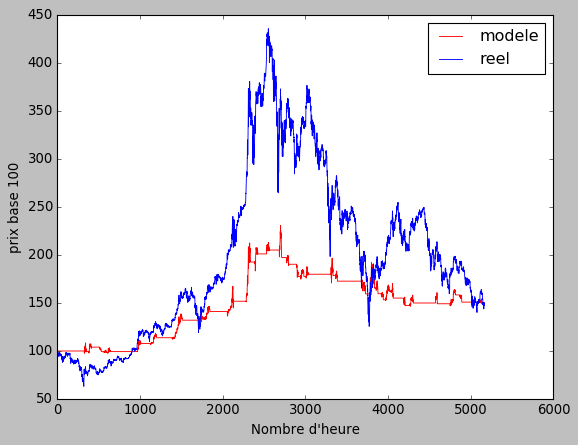

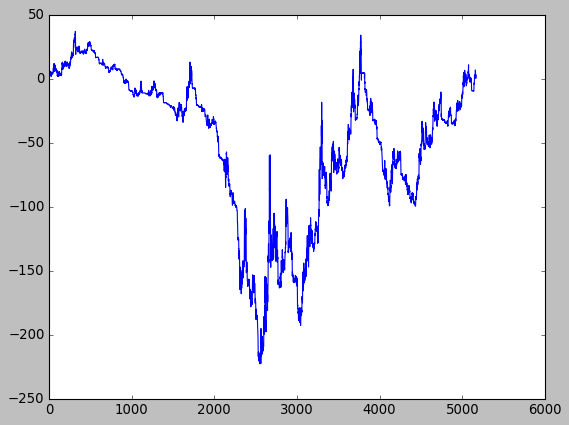

In [178]:

df_test = macd_perso(df_shift)

predictions = df_test['macd_action'].values.tolist()
variation = df_test['variation'].values.tolist()

gain_pourcent,liste_variation, hold, achat, vente, free_cash, depenses_commission = Gain_hypothetique(predictions, variation)

difference = [b_elt - a_elt for a_elt, b_elt in zip(liste_variation, gain_pourcent)]

benef_4000_modele = gain_pourcent[-1] - gain_pourcent[4000]
benef_4000_reel = liste_variation[-1] - liste_variation[4000]
ecart_modele_reelle_actuel =  difference[-1] - difference[4000]

print("Variation réelle = ", str(round(liste_variation[-1] - 100,2)), "%.")
print("Gain total = ", str(round(gain_pourcent[-1] - 100,2)), "%.")
print("Nombre de transactions = ", str(achat + vente))
print("Argent dépensé en commissions = ", str(round(depenses_commission[-1] - 100, 2)), "%.")
print("Nombre de chandeliers sans cash engagé = ", str(free_cash))
print("Nombre de chandeliers sur lesquels on a juste hold = ", str(hold))
print("Evolution gain modèle depuis la 4000eme heure",str(round(benef_4000_modele, 2)), "%.")
print("Evolution gain réel depuis la 4000eme heure",str(round(benef_4000_reel, 2)), "%.")
print("Ecart gain du modele par rapport au réel depuis la 4000eme heure", str(round(ecart_modele_reelle_actuel, 2)), "%.")

L = [i for i in range (len(gain_pourcent))]
J = [i for i in range (len(liste_variation))]

plt.plot(L,gain_pourcent,linewidth=0.8,color='r',label="modele")
plt.plot(J,liste_variation,linewidth=0.8,color='b',label="reel")

plt.xlabel("Nombre d'heure")
plt.ylabel("prix base 100")
plt.legend()
plt.show()

K = [i for i in range (len(difference))]
plt.plot(K, difference)
plt.show()

5165
[ 0.01485336  0.0078429   0.0236405  ...,  0.01557721  0.0236405   0.0078429 ]
142


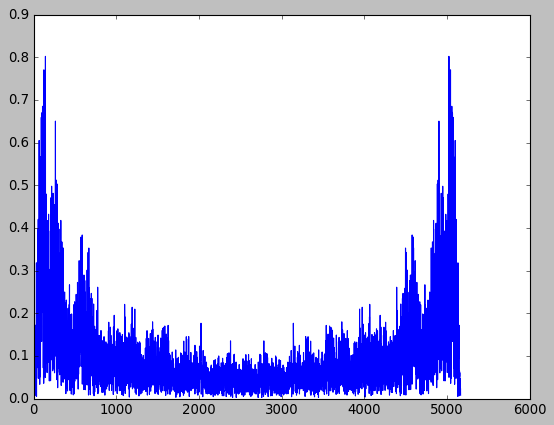

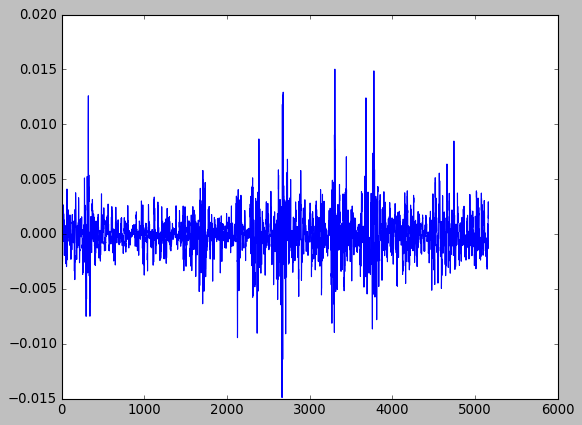

In [137]:
from scipy.fftpack import fft, fftfreq
"""
i = -80
copy = i
liste_gain = []
liste_difference = []
while i < -20:
    df_test = macd_perso(df_shift, shift = i)

    predictions = df_test['macd_action'].values.tolist()
    variation = df_test['variation'].values.tolist()

    gain_pourcent,liste_variation, hold, achat, vente, free_cash, depenses_commission = Gain_hypothetique(predictions, variation)
    i += 1
    liste_gain.append(gain_pourcent[-1] - 100)
    
    #difference = [b_elt - a_elt for a_elt, b_elt in zip(liste_variation, gain_pourcent)]
    #liste_difference.append(difference[-1] - difference[4500])
    liste_difference.append(gain_pourcent[-1] - gain_pourcent[4500])
 

plt.plot(T,liste_gain,linewidth=0.8,color='b',label="gain sur 6 mois")
plt.xlabel('nombre de shift')
plt.ylabel('gain en pourcent')
D = [i for i in range (copy, copy + len(liste_difference))]
plt.plot(D,liste_difference,linewidth=0.8,color='r',label="gain sur 1 mois")
plt.legend()
plt.show()
"""   
macd = df_shift['derivate_macd_n'].values.tolist()

T = [i for i in range (len(macd))]
macd = np.asarray(macd)

signal_FFT = abs(fft(macd))

print(len(signal_FFT))
plt.show()

print(signal_FFT)
print(np.argmax(signal_FFT))
plt.plot(signal_FFT)
plt.show()
plt.plot(T,macd)
plt.show()


Partie 3 : Bandes de Bollinger
====
Introduction : Theory explanation
----
Les bandes de Bollinger is an indicator composed of 3 courbes. The central one is an 
arithmetic average of our last 20 (or 50 ?) closing value. On both side of this central 
courbe We have one bande de Bollinger. The one below is the bdb_low the one above is the 
bdb_high. Theorically, les bandes de Bollinger are separated from the central one of
2 ecart type. 
This indicator makes sense as we are supposing that our chandeliers are following a loi
normale, which means that we have as an average 5% of our closing value that are outside 
of the bande de Bollinger. To this end, if we are out of this zone, we can consider that 
most of the time our next closing values will go back in the bande de bollinger quickly.
During all this part, we are going to define our own space between the Bande de Bollinger
and not just try with the 2 ecart type space.

Let's take an example for one threshold (the space between one bande de bollinger and the
courbe center).

If we are at a moment t out of the Bande de Bollinger we are going to ask our model to sell 
(or to buy depending on which courbe de Bollinger we are).

Our purpose is to find this optimum value of threshold for each Bande de Bollinger.

I Bandes de Bollinger basse
====
1) Vector Creation
----
We create our bdb_low vector that is going to be easy to understand for our final algorithm.
1 if we are out of the bdb_low, else 0.

In [138]:
def bdb_low_perso_fonction(df, seuil = 1.0348):
    
    bdb_low = df['bdb_low_n'].values.tolist()
    bdb_low_perso = []
    
    for i in range(len(bdb_low)):
        
        if bdb_low[i] >= seuil:
            bdb_low_perso.append(1)
        else:
            bdb_low_perso.append(0)
            
    return(bdb_low_perso)

2) Gain function creation
====
The important thing to know is that sometimes we have two of three values following each other
out of the Bande de Bollinger. Most of the time the sum of those values is still a benefit for
ourselves. But we have to be careful about this when we are calculating our gain.


In [139]:
def gain(bdb_low_perso, variation, commission = 0.3):
    
    cash = True
    gain_pourcent = [100]
    liste_variation = [100]
    gain_transaction = [100]
    gain_hold = [100]
    free_cash = 0
    achat = 0
    vente = 0
    hold = 0
    
    for i in range (len(bdb_low_perso)):
        
        liste_variation.append(liste_variation[-1] * (100 + variation[i]) / 100)
        
        if bdb_low_perso[i] == 1 and cash:
            cash = False
            gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i] - commission) / 100)
        
        elif bdb_low_perso[i] == 1 and not cash:
            gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i]) / 100)
        
        elif bdb_low_perso[i] == 0 and cash:
            gain_pourcent.append(gain_pourcent[-1])
       
        elif bdb_low_perso[i] == 0 and not cash:
            gain_pourcent.append(gain_pourcent[-1]*(100 - commission) / 100)
            cash = True
            
        else:
            print('SOUCI')
            
    return(liste_variation, gain_pourcent)

3) Threshold optimisation function
====
Will give us back the threshold and some other useful measurements.

In [140]:
def bdb_low_threshold_optimisation(df,debut = 1.05, fin = 1.025):
    variation = df['variation'].values.tolist()
    optimisation = []
    first = debut
    while debut >= fin:

        bdb_low_perso = bdb_low_perso_fonction(df, seuil = debut)
        liste_variation, gain_pourcent = gain(bdb_low_perso, variation)

        debut = debut - 0.0001


        optimisation.append(gain_pourcent[-1])

    L = [i for i in range(len(optimisation))]

    max_index = optimisation.index(max(optimisation))
    threshold = first - max_index * 0.0001
    bdb_low_perso = bdb_low_perso_fonction(df, seuil = threshold)
    
    number_activation = bdb_low_perso.count(1)

    print('Max_gain = ' + str(round(max(optimisation),3)) + "%.")
    print("Threshold = " + str(round(threshold,4)))
    print('Number of activations = ' + str(number_activation))
    plt.plot(L, optimisation)
    plt.xlabel('Threshold en unité arbitraires')
    plt.ylabel('Gain max en %')
    plt.show()
    
    return(threshold, bdb_low_perso)


4)Visualisation
====
After all those functions we are going to visualize our results

Results
----
max gain = 99.7%

Interpretation :
----
We can see on our graphics that we are gaining money on big quick variations. This indicator was very powerful during the bubble
time, maybe it is going to be less useful as now those bubble effects are less important.
At the beggining of this optimisation, we have said that sometimes we have two or three times in a row the closing value superior to the bande de Bollinger. We can see on our graphic those points those pics vers le bas which remontent instantaneously.

Max_gain = 187.253%.
Threshold = 1.0279
Number of activations = 125


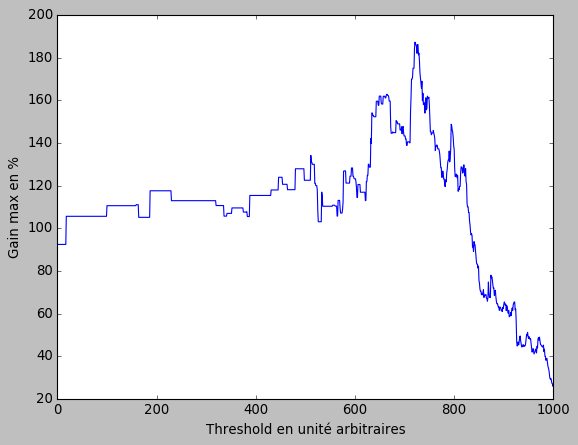

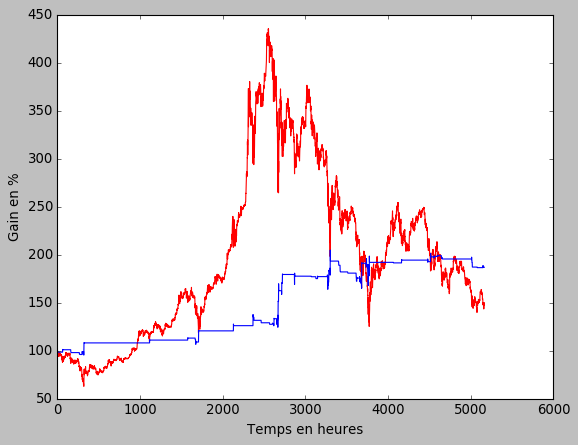

In [141]:
df_bdb_low_etude = df_shift.copy()
threshold, bdb_low_perso = bdb_low_threshold_optimisation(df_bdb_low_etude, debut = 1.10, fin = 1)
liste_variation, gain_pourcent = gain(bdb_low_perso, variation)

L = [i for i in range(len(gain_pourcent))]
J = [j for j in range (len(liste_variation))]

plt.plot(J, liste_variation, color = 'r')
plt.xlabel('Temps en heures')
plt.ylabel('Gain en %')
plt.plot(L,gain_pourcent)

plt.show()

II Bande de Bollinger haute
====
1) Vector creation
----
We create our bdb_high vector that is going to be easy to understand for our final algorithm. 1 if we are out of the bdb_high, else 0.

In [142]:
def bdb_high_perso_fonction(df, seuil = 0.9542):
    
    bdb_high = df['bdb_high_n'].values.tolist()
    bdb_high_perso = []
    
    for i in range(len(bdb_high)):
        
        if bdb_high[i] <= seuil:
            bdb_high_perso.append(1)
        if bdb_high[i-1] <= seuil:
            bdb_high_perso.append(1)
        else:
            bdb_high_perso.append(0)
            
    return(bdb_high_perso)


2) Gain function creation
====

In [143]:
def gain(bdb_high_perso, variation, commission = 0.3):
    
    cash = True
    gain_pourcent = [100]
    liste_variation = [100]
    
    for i in range (len(bdb_high_perso)):
        
        liste_variation.append(liste_variation[-1] * (100 + variation[i]) / 100)
        
        if bdb_high_perso[i] == 1 and cash:
            cash = False
            gain_pourcent.append(gain_pourcent[-1]*(100 - variation[i] - commission) / 100)
            
        elif bdb_high_perso[i] == 1 and not cash:
            gain_pourcent.append(gain_pourcent[-1]*(100 - variation[i]) / 100)
            
        elif bdb_high_perso[i] == 0 and cash:
            gain_pourcent.append(gain_pourcent[-1])
            
        elif bdb_high_perso[i] == 0 and not cash:
            gain_pourcent.append(gain_pourcent[-1]*(100 - commission) / 100)            
            cash = True
            
        else:
            print('SOUCI')
            
    return(liste_variation, gain_pourcent)




3) Threshold optimisation function
====
Will give us back the threshold and some other useful measurements.

In [144]:
def bdb_high_threshold_optimisation(df, debut = 0.95, fin = 0.98):
    variation = df['variation'].values.tolist()
    optimisation = []
    first = debut
    while debut <= fin:

        bdb_high_perso = bdb_high_perso_fonction(df, seuil = debut)
        liste_variation, gain_pourcent = gain(bdb_high_perso, variation)

        debut = debut + 0.0001


        optimisation.append(gain_pourcent[-1])

    L = [i for i in range(len(optimisation))]

    min_index = optimisation.index(max(optimisation))
    threshold = first + min_index * 0.0001
    bdb_high_perso = bdb_high_perso_fonction(df, seuil = threshold)
    number_activation = bdb_high_perso.count(1)

    print('Max_gain = ' + str(round(max(optimisation),3)) + "%.")
    print("Threshold = " + str(round(threshold,4)))
    print('Number of activations = ' + str(number_activation))
    
    plt.plot(L,optimisation)
    plt.xlabel('Threshold en unité arbitraires')
    plt.ylabel('Gain max en %')
    plt.show()
    
    return(threshold, bdb_high_perso)

4)Visualisation
====
After all those functions we are going to visualize our results

Results
----
max gain = -25.954%

Interpretation :
----
We can see on our graphics that we are gaining money on big quick variations. This indicator was very powerful during the bubble
time, maybe it is going to be less useful as now those bubble effects are less important.
At the beggining of this optimisation, we have said that sometimes we have two or three times in a row the closing value 
superior to the bande de Bollinger. We can see on our graphic those points those pics vers le haut which redescendent
instantaneously.
We can also see that the Bande de Bollinger haute is less efficient than the Bande de bollinger basse. Which could be explained
by the fact that investors were most of the time thinking that the bitcoin value was going to high. Like for them it was very
rarely surévalué even if this augmentation was very important (kind of exponential).


In [145]:
df_bdb_high_etude = df_shift.copy()
threshold, bdb_high_perso = bdb_high_threshold_optimisation(df_bdb_high_etude, debut = 0.90, fin = 1.2)
liste_variation, gain_pourcent = gain(bdb_high_perso, variation)

L = [i for i in range(len(gain_pourcent))]
J = [j for j in range (len(liste_variation))]

plt.plot(J, liste_variation)
plt.xlabel('Temps en heures')
plt.ylabel('Gain en %')
plt.plot(L, gain_pourcent)

plt.show()

IndexError: list index out of range

Conclusion
====
Those Bande de Bollinger are a precious indicator on our dataframe as we are able to have a gain of 125% on the maximum. 
We need now to cross this indicator with MACD to see if there are complementary indicators.


Partie 4 : MACD & Bandes de Bollinger
====
I Vectors creation
----
Firstly we are going to create all our vectors to secondly exploit them.

In [161]:
df_test = df_shift.copy()

"MACD part"
df_test = macd_perso(df_shift)

"bdb_high part"
bdb_high_list = bdb_high_perso_fonction(df_shift, seuil = 0.8) #0.9645
array_bdb_high = np.asarray(bdb_high_list)
df_bdb_high = pd.DataFrame(array_bdb_high,columns = ['bdb_high_action'])
df_test=pd.concat([df_bdb_high, df_test], axis=1)

"bdb_low part"
bdb_low_list = bdb_low_perso_fonction(df_shift, seuil = 1.0348) #1.0348
array_bdb_low = np.asarray(bdb_low_list)
df_bdb_low = pd.DataFrame(array_bdb_low,columns = ['bdb_low_action'])
df_test=pd.concat([df_bdb_low, df_test], axis=1)
df_test.dropna(inplace = True)
print(df_test.head())


   bdb_low_action  bdb_high_action  macd_action_a  variation  macd_action
0               0                0              0   0.350023            0
1               0                0              0  -4.397400            0
2               0                0              0   3.518990            0
3               1                0              0  -0.592246            0
4               0                0              0  -0.144347            0


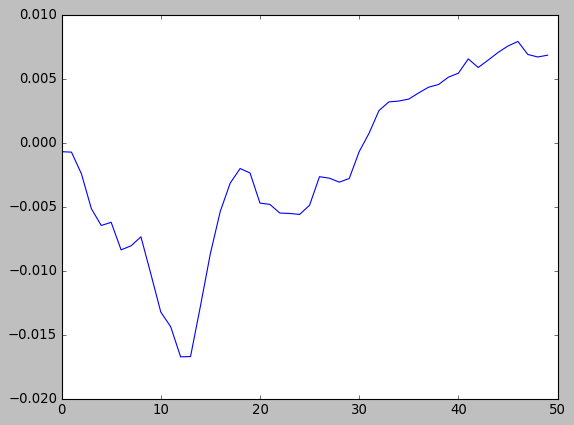

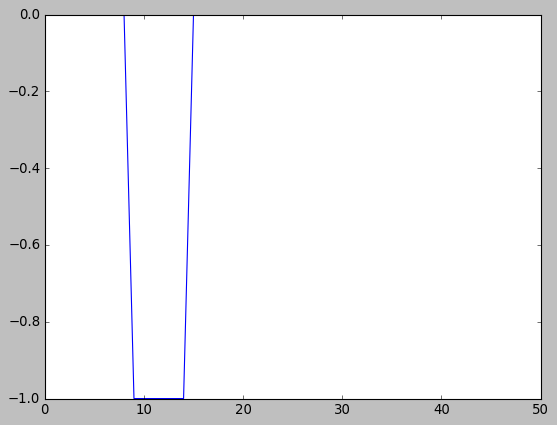

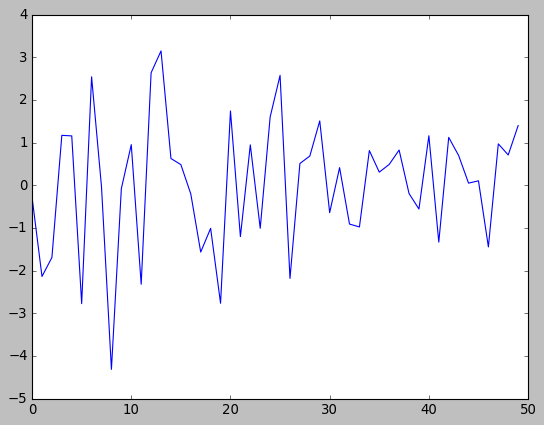

In [162]:
action = df_test['macd_action'].values.tolist()
macd = df_shift['macd_n'].values.tolist()
variation = df_test['variation'].values.tolist()

action_deb = action[50:100]
macd_deb = macd[50:100]
variation_deb = variation[50:100]

L = [i for i in range (len(action_deb))]

plt.plot(L,macd_deb)
plt.show()
plt.plot(L,action_deb)
plt.show()
plt.plot(L,variation_deb)
plt.show()

II Gain function
====

In [163]:
"""def gain(bdb_high_perso, bdb_low_perso, predictions, variation, commission = 0.3):
    a=0
    v=0
    
    cash = True
    gain_pourcent = [0]
    liste_variation = [0]
    gain_macd = [0]
    gain_high = [0]
    gain_low = [0]
    for i in range (len(bdb_high_perso)):
        
        liste_variation.append(liste_variation[-1] + variation[i])
        
        if bdb_high_perso[i] == 1 and cash:
            gain_pourcent.append(gain_pourcent[-1])
            gain_high.append(gain_high[-1] - variation[i])
            
        elif bdb_high_perso[i] == 1 and not cash:
            cash = True
            gain_pourcent.append(gain_pourcent[-1] - commission)
            gain_high.append(gain_high[-1] - commission -variation[i])
            v=v+1
            
        elif bdb_low_perso[i] == 1 and cash:
            a=a+1            
            cash = False
            gain_low.append(gain_low[-1] - commission + variation[i])
            gain_pourcent.append(gain_pourcent[-1] + variation[i] - commission)
        
        elif bdb_low_perso[i] == 1 and not cash:
            
            gain_pourcent.append(gain_pourcent[-1] + variation[i])
            gain_low.append(gain_low[-1] + variation[i])
            
        elif bdb_high_perso[i] == 0 and bdb_low_perso[i] == 0 and cash:
            
            
            if predictions[i] == 1:
                a=a+1
                cash = False
                gain_macd.append(gain_macd[-1] - commission + variation[i])
                gain_pourcent.append(gain_pourcent[-1] - commission + variation[i])
            
            elif predictions[i] == -1:
                gain_pourcent.append(gain_pourcent[-1])

            elif predictions[i] == 0:
                gain_pourcent.append(gain_pourcent[-1])
            
        elif bdb_high_perso[i] == 0 and bdb_low_perso[i] == 0 and not cash:
            
            
            if predictions[i] == 0:
                gain_macd.append(gain_macd[-1] + variation[i])
                gain_pourcent.append(gain_pourcent[-1] + variation[i])
            
            elif predictions[i] == -1:
                v=v+1
                cash = True
                gain_pourcent.append(gain_pourcent[-1] - commission)
                gain_macd.append(gain_macd[-1] - commission)

            elif predictions[i] == 1:
                gain_macd.append(gain_macd[-1] + variation[i])
                gain_pourcent.append(gain_pourcent[-1] + variation[i])
            
        else:
            print('SOUCI')
            
    return(liste_variation, gain_pourcent,a,v,gain_macd,gain_low,gain_high)

predictions = df_test['macd_perso'].values.tolist()
variation = df_test['variation'].values.tolist()
bdb_high_perso = df_test['bdb_high_perso'].values.tolist()
bdb_low_perso = df_test['bdb_low_perso'].values.tolist()

liste_variation, gain_pourcent,a,v,gain_macd,gain_low,gain_high = gain(bdb_high_perso, bdb_low_perso, predictions, variation, commission = 0.3)
print(a,v,gain_macd[-1],gain_low[-1],gain_high[-1])
L = [i for i in range(len(gain_pourcent))]
J = [j for j in range (len(liste_variation))]
print(gain_pourcent[-1])
plt.plot(J,liste_variation)
plt.xlabel('Temps en heures')
plt.ylabel('Gain en %')
plt.plot(L,gain_pourcent)

plt.show()"""


"def gain(bdb_high_perso, bdb_low_perso, predictions, variation, commission = 0.3):\n    a=0\n    v=0\n    \n    cash = True\n    gain_pourcent = [0]\n    liste_variation = [0]\n    gain_macd = [0]\n    gain_high = [0]\n    gain_low = [0]\n    for i in range (len(bdb_high_perso)):\n        \n        liste_variation.append(liste_variation[-1] + variation[i])\n        \n        if bdb_high_perso[i] == 1 and cash:\n            gain_pourcent.append(gain_pourcent[-1])\n            gain_high.append(gain_high[-1] - variation[i])\n            \n        elif bdb_high_perso[i] == 1 and not cash:\n            cash = True\n            gain_pourcent.append(gain_pourcent[-1] - commission)\n            gain_high.append(gain_high[-1] - commission -variation[i])\n            v=v+1\n            \n        elif bdb_low_perso[i] == 1 and cash:\n            a=a+1            \n            cash = False\n            gain_low.append(gain_low[-1] - commission + variation[i])\n            gain_pourcent.append(gai

In [164]:
def Gain_total(bdb_high_action, bdb_low_action, macd_action, variation, commission = 0.3):
    cash = True
    gain_pourcent = [100]
    gain_macd = [0]
    gain_bdb_low = [0]
    gain_bdb_high = [0]
    achat = 0
    vente = 0
    hold = 0
    free_cash = 0
    liste_variation = [100]
    print(len(bdb_high_action))
    gain_action = [0]
    gain_hold = [0]
    
    for i in range(len(bdb_high_action)):        
        liste_variation.append(liste_variation[-1] * (100 + variation[i]) / 100)
        
        #si les bollinger ne permettent pas d'affirmer quoi que ce soit  et qu'on a du cash alors on demande à la MACD"
        if bdb_high_action[i] == 0 and bdb_low_action[i] == 0 and cash:
            
            #si macd dit que ca va descendre alors on fait rien"
            if macd_action[i] == -1:
                gain_pourcent.append(gain_pourcent[-1])
                free_cash += 1
            #si macd ne sait pas alors on ne fait rien"
            elif macd_action[i] == 0:
                gain_pourcent.append(gain_pourcent[-1])
                free_cash += 1               
            #si macd dit que ca va monter alors on achète"
            elif macd_action[i] == 1:
                gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i] - commission) / 100)
                gain_macd.append(gain_macd[-1] + variation[i] - commission)
                achat += 1
                gain_action.append(gain_action[-1] + variation[i] - commission)
                cash = False
        
        #si les bollinger ne permettent pas d'affirmer quoi que ce soit et qu'on a pas de cash alors on demande à la MACD
        elif bdb_high_action[i] == 0 and bdb_low_action[i] == 0 and not cash:
            #si macd dit que ca va descendre alors on revend"
            if macd_action[i] == -1:
                gain_pourcent.append(gain_pourcent[-1]*(100 - commission) / 100)
                gain_macd.append(gain_macd[-1] - commission)
                vente += 1
                gain_action.append(gain_action[-1] - commission)
                cash = True
                
            #si macd ne sait pas alors on ne fait rien"
            elif macd_action[i] == 0:
                gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i]) / 100)
                gain_macd.append(gain_macd[-1] + variation[i])
                gain_hold.append(gain_hold[-1] + variation[i])
                hold += 1
                
            #si macd dit que ca va monter alors on ne fait rien"
            elif macd_action[i] == 1:
                gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i]) / 100)
                gain_macd.append(gain_macd[-1] + variation[i])
                gain_hold.append(gain_hold[-1] + variation[i])
                hold += 1
        
        #si bdb_high dit que ca va descendre et qu'on a du cash alors on ne fait rien"
        elif bdb_high_action[i] == 1 and cash:
            gain_pourcent.append(gain_pourcent[-1])
            free_cash += 1
                
        #si bdb_high dit que ca va descendre et qu'on n'a pas de cash alors on revend"  
        elif bdb_high_action[i] == 1 and not cash:
            gain_pourcent.append(gain_pourcent[-1]*(100 - commission) / 100)
            vente += 1
            gain_action.append(gain_action[-1] - commission)
            cash = True
            gain_bdb_high.append(gain_bdb_high[-1] - variation[i] - commission)

                
        #si bdb_low dit que ca va monter et qu'on a du cash alors on achète"        
        elif bdb_low_action[i] == 1 and cash:
            achat += 1
            gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i] - commission) / 100)
            cash = False
            gain_pourcent.append(gain_pourcent[-1] + variation[i] - commission)
            gain_bdb_low.append(gain_bdb_low[-1] + variation[i] - commission)

        #si bdb_low dit que ca va monter et qu'on n'a pas de cash alors on fait rien"        
        elif bdb_low_action[i] == 1 and not cash: 
            hold += 1
            gain_hold.append(gain_hold[-1] + variation[i])
            gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i]) / 100)
            gain_bdb_low.append(gain_bdb_low[-1] + variation[i])
        else:
            print('il y a une ambiance')
        
                
    return(gain_pourcent, liste_variation, gain_bdb_low, gain_bdb_high, gain_macd, achat, vente, hold, free_cash, gain_action, gain_hold)      

5165
gain_bdb_low =  73.72 %.
gain_bdb_high =  0 % évités.
gain_macd =  113.97 %.
Gain total =  535.7 %.
Nombre de transactions =  146
Argent dépensé en commissions =  43.8 %.
Nombre de chandeliers sans cash engagé =  2367
Nombre de chandeliers sur lesquels on a juste hold =  2652
Gain réalisé lors des transactions =  -27.08 %.
Gain réalisé lors des holds =  175.66 %.


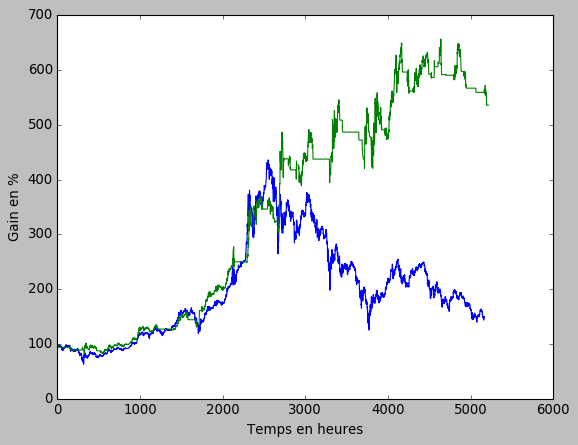

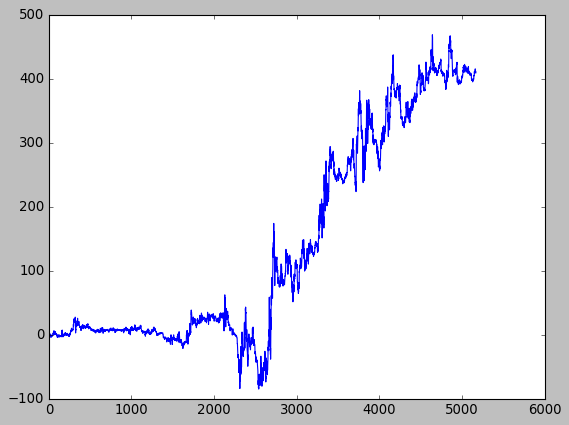

In [166]:
bdb_high_action = df_test['bdb_high_action'].values.tolist()
bdb_low_action = df_test['bdb_low_action'].values.tolist()
macd_action = df_test['macd_action'].values.tolist()
variation = df_test['variation'].values.tolist()
gain_pourcent, liste_variation, gain_bdb_low, gain_bdb_high, gain_macd, achat, vente, hold, free_cash, gain_action, gain_hold = Gain_total(bdb_high_action, bdb_low_action, macd_action, variation)

print("gain_bdb_low = ", str(round(gain_bdb_low[-1],2)), "%.")
print("gain_bdb_high = ", str(round(gain_bdb_high[-1],2)), "% évités.")
print("gain_macd = ", str(round(gain_macd[-1],2)), "%.")
print("Gain total = ", str(round(gain_pourcent[-1],2)), "%.")
print("Nombre de transactions = ", str(achat + vente))
print("Argent dépensé en commissions = ", str(0.3*(achat + vente)), "%.")
print("Nombre de chandeliers sans cash engagé = ", str(free_cash))
print("Nombre de chandeliers sur lesquels on a juste hold = ", str(hold))
print("Gain réalisé lors des transactions = ", str(round(gain_action[-1],2)), "%.")
print("Gain réalisé lors des holds = ", str(round(gain_hold[-1],2)), "%.")

difference = [b_elt - a_elt for a_elt, b_elt in zip(liste_variation, gain_pourcent)]

L = [i for i in range(len(gain_pourcent))]
J = [j for j in range (len(liste_variation))]
D = [j for j in range(len(difference))]
plt.plot(J,liste_variation)
plt.xlabel('Temps en heures')
plt.ylabel('Gain en %')
plt.plot(L,gain_pourcent)

plt.show()
plt.plot(D, difference)
plt.show()

Résultats
====

données entrée : bdb_high = 0.9542 bdb_low = 1.0348 MACD_strat_opti

données sortie : gain = 128.34 transactions = 185
    
données entrée : bdb_high = 0.9542 bdb_low = 1.0293 MACD_strat_opti

données sortie : gain = 123.74 transactions = 211 
    
données entrée : bdb_high = 0.9704 bdb_low = 1.0348 MACD_strat_opti

données sortie : gain = 124.50 transactions = 219
    
données entrée : bdb_high = 0.9645 bdb_low = 1.0348 MACD_strat_opti

données sortie : gain = 126.35 transactions = 198


Partie 5 : Stochastic
====
1) Vector Creation
----
For this one we are going to create a strategy that follows (depending on the threshold) the classic strategy. That means
buy when the stochastic is passing above the threshold_a and sell when it is passing below threshold_v.

stochastique_opti = 0.05213
gain = 82.55%

stochastique_opti = 0.27
gain = 278.95%
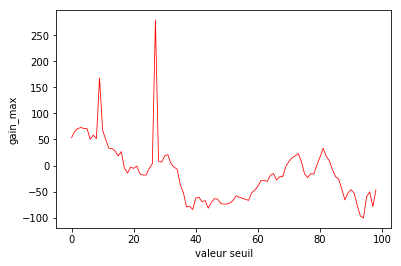

In [167]:
df_stochastic = df_shift.copy()
df_stochastic
def decision_stoch(df,seuil=0.27):
    
    derivate_stochastic=df['derivate_stochastic'].values.tolist()
    stochastic=df['stochastic'].values.tolist()
    stochastic_shift=df['stochastic'].shift(1).values.tolist()
    marqueur = False
    stochastic_action=[]
    
    for j in range(len(stochastic)):


        #si on augmente mais qu'on etait dans une tendance baissiere
        if derivate_stochastic[j] >= 0 and not marqueur:

            #on passe le seuil donc on active le marqueur de tendance haussiere
            if stochastic_shift[j] <= seuil and stochastic[j] > seuil:
                marqueur = True
                stochastic_action.append(1)
                
            #le seuil n'est pas atteint malgré la hausse on bouge pas le marqueur mais petit achat
            elif stochastic_shift[j] <= seuil and stochastic[j] <= seuil:
                stochastic_action.append(0)
             #on etait en tendance baissiere mais les valeurs remontent avant de repasser sous le seuil
             #pour le moment on garde le seuil a 1 (car forte correlation dans nos calculs) meme
             #si ceci arrive mais on garde petite hausse quand meme
            elif stochastic_shift[j] > seuil:
                stochastic_action.append(0)
                marqueur = True
                #si tendance haussiere et hausse
                
        elif derivate_stochastic[j] >= 0 and marqueur:
            stochastic_action.append(1)
            
        #si tendance baissiere et baisse
        elif derivate_stochastic[j] < 0 and not marqueur:
            stochastic_action.append(-1)
            
        #si tendance haussiere et baisse
        elif derivate_stochastic[j] < 0 and marqueur:
            #on passe le seuil de baisse donc desactive le marqueur de hausse
            if stochastic[j] < 1 - seuil and stochastic_shift[j] > 1 - seuil:
                stochastic_action.append(-1)
                marqueur = False
                
            #on ne passe pase le seuil donc conserve le seuil hausse mais faible valeur d'achat
            elif stochastic[j] >= 1 - seuil:
                stochastic_action.append(0)
            #ceci correspond a ce que pendant une tendance haussiere une baisse se produit sans avoir
            #touché le seuil du haut ni retomber sur le seuil du bas donc a definir plus tard 
            #nous prenons le choix de mettre le compteur a 1 car plus forte correlation 
            elif stochastic_shift[j] < 1 - seuil and stochastic [j] <=  1 - seuil:
                stochastic_action.append(0)
                marqueur = True
        else:
            stochastic_action.append(0)
            print('erreur') 
    return(stochastic_action)


2) Function gain
====

In [168]:
def Gain_hypothetique(predictions, variation, commission = 0.3):

    cash=True
    gain_pourcent=[100]
    liste_variation=[100]
    depenses_commission = [0]
    transaction = 0

    for i in range(len(variation) - 1):
        
        liste_variation.append(liste_variation[-1] * (100 + variation[i]) / 100)

        if predictions[i] == 1 and cash:
            
            cash = False
            gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i] - commission) / 100)
            depenses_commission.append(depenses_commission[-1] + gain_pourcent[-1] * commission / 100)
            transaction += 1
            
        elif predictions[i] == -1 and cash:
            gain_pourcent.append(gain_pourcent[-1])
            
        elif predictions[i] == -1 and not cash:
            cash = True
            gain_pourcent.append(gain_pourcent[-1]*(100 - commission) / 100)
            depenses_commission.append(depenses_commission[-1] + gain_pourcent[-1] * commission / 100)
            transaction += 1

        elif predictions[i] == 1 and not cash:
            gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i]) / 100)

        elif predictions[i] == 0 and cash:
            gain_pourcent.append(gain_pourcent[-1])

        elif predictions[i] == 0 and not cash:
            gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i]) / 100)
        
        else:
            print('MERDE')

            
    return(gain_pourcent,liste_variation, depenses_commission, transaction)


3) optimisation threshold function
====

In [169]:
df_stochastic = df_shift.copy()
df_stochastic = df_stochastic.iloc[0:4000]
p = 0.001
liste_gain = []
while p<=0.5:
    stochastique_action = decision_stoch(df_stochastic,seuil=p)
    variation = df_shift['variation'].values.tolist()
    gain_pourcent,liste_variation,depenses_commission,transaction = Gain_hypothetique(stochastique_action, variation)
    liste_gain.append(gain_pourcent[-1])
    p = p + 0.001

    
L = [i for i in range (len(liste_gain))]
J = [i for i in range (len(liste_variation))]

#print(gain_pourcent[-1],liste_variation[-1])

plt.plot(L,liste_gain,linewidth=0.8,color='r',label="variation en %")
plt.xlabel("valeur seuil")
plt.ylabel("gain_max")
plt.show()

IndexError: list index out of range

4) Visualisation
====

In [170]:
print(max(liste_gain))
print(liste_gain.index(max(liste_gain)))

ValueError: max() arg is an empty sequence

Nombre de transactions =  1160
Argent dépensé en commissions =  76.36 %.
31.068447619932677 148.57708333655052


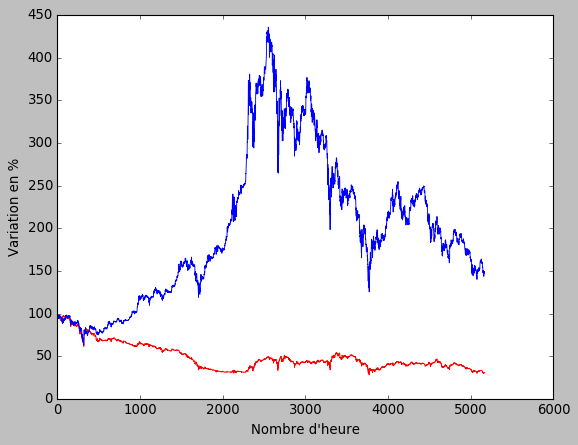

In [171]:
df_stochastic = df_shift.copy()
stochastique_action = decision_stoch(df_stochastic,seuil=0.064)
variation = df_shift['variation'].values.tolist()
gain_pourcent,liste_variation, depenses_commission, transaction = Gain_hypothetique(stochastique_action, variation)
liste_gain.append(gain_pourcent[-1])
print("Nombre de transactions = ", str(transaction))
print("Argent dépensé en commissions = ", str(round(depenses_commission[-1] - 100, 2)), "%.")

L = [i for i in range (len(gain_pourcent))]
J = [i for i in range (len(liste_variation))]

print(gain_pourcent[-1],liste_variation[-1])

plt.plot(L,gain_pourcent,linewidth=0.8,color='r',label="variation en %")
plt.xlabel("valeur seuil")
plt.ylabel("gain_max")


plt.plot(J,liste_variation,linewidth=0.8,color='b',label="variation en %")
plt.xlabel("Nombre d'heure")
plt.ylabel("Variation en %")
plt.show()

   bdb_low_action  macd_action_a  variation  macd_action
0               0              0   0.350023            0
1               0              0  -4.397400            0
2               0              0   3.518990            0
3               1              0  -0.592246            0
4               0              0  -0.144347            0
Variation réelle =  119.36 %.
Gain total =  120.21 %.
Nombre de transactions =  1
Nombre de chandeliers sans cash engagé =  3
Nombre de chandeliers sur lesquels on a juste hold =  3996


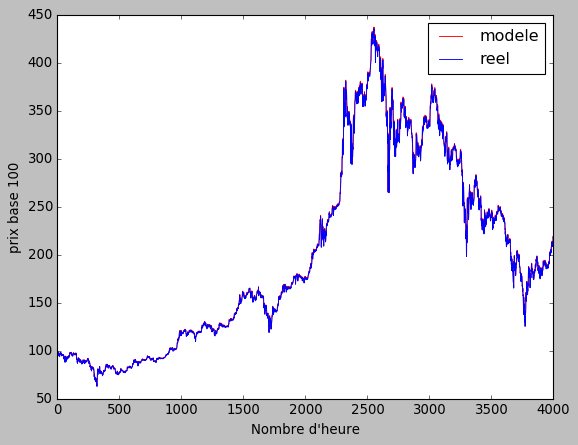

Variable: bdb_low_action       Importance: 0.79
Variable: macd_action          Importance: 0.11


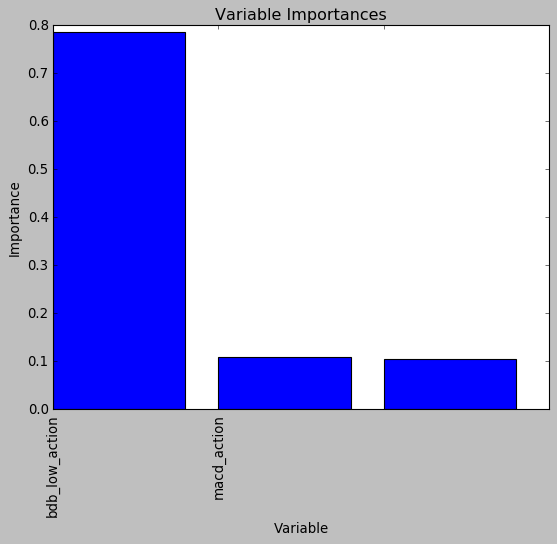

"from sklearn import tree\nfrom os import system\nimport graphviz \ndf_X = pd.DataFrame(X_train, columns = ['stochastic_action', 'bdb_low_action', 'bdb_high_action', 'macd_action'])\n \n\nclf = tree.DecisionTreeRegressor()\nclf = clf.fit(X_train, y_train)\n\ndot_data = tree.export_graphviz(clf, out_file=None, \n                         feature_names=['stochastic_action', 'bdb_low_action', 'bdb_high_action', 'macd_action'],  \n                         class_names='predictions',  \n                         filled=True, rounded=True,  \n                         special_characters=True)  \ngraph = graphviz.Source(dot_data) \nprint(graph)"

In [173]:
df_test = df_shift.copy()

#MACD part
df_test = macd_perso(df_shift)

"""#bdb_high part
bdb_high_list = bdb_high_perso_fonction(df_shift, seuil = 0.9645)
array_bdb_high = np.asarray(bdb_high_list)
df_bdb_high = pd.DataFrame(array_bdb_high,columns = ['bdb_high_action'])
df_test=pd.concat([df_bdb_high, df_test], axis=1)"""

#bdb_low part
bdb_low_list = bdb_low_perso_fonction(df_shift, seuil = 1.0348)
array_bdb_low = np.asarray(bdb_low_list)
df_bdb_low = pd.DataFrame(array_bdb_low,columns = ['bdb_low_action'])
df_test=pd.concat([df_bdb_low, df_test], axis=1)

"""#stochastic part
stochastic_action_list = decision_stoch(df_shift, seuil = 0.064)
array_stochastic_action = np.asarray(stochastic_action_list)
df_stochastic = pd.DataFrame(array_stochastic_action,columns = ['stochastic_action'])
df_test=pd.concat([df_stochastic, df_test], axis=1)
df_test.dropna(inplace = True)
df_test = df_test.drop('macd_action_a', axis = 1)"""
print(df_test.head())

X = df_test.drop('variation', axis = 1)
y = df_test['variation']

X_train = X.iloc[0:4000,:].values
X_test = X.iloc[4000:,:].values

y_train = y.iloc[0:4000].values
y_test = y.iloc[4000:].values

from sklearn.ensemble import RandomForestRegressor

final_model=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=10,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False, random_state=19,
           verbose=0, warm_start=False) 

clf=final_model
clf.fit(X_train, y_train)

predictions = clf.predict(X_train)
variation = y_train

def gain(predictions, variation, commission = 0.3, seuil = 0.3):
    
    cash = True
    gain_pourcent = [100]
    liste_variation = [100]
    free_cash = 0
    achat = 0
    vente = 0
    hold = 0
    
    for i in range (len(predictions)):
        
        liste_variation.append(liste_variation[-1] * (100 + variation[i]) / 100)
        
        if predictions[i] >= seuil and cash:
            cash = False
            gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i] - commission) / 100)
            achat += 1
        
        elif predictions[i] >= seuil and not cash:
            gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i]) / 100)
            hold += 1
        
        elif predictions[i] <= - seuil and cash:
            gain_pourcent.append(gain_pourcent[-1])
            free_cash += 1
       
        elif predictions[i] <= - seuil and not cash:
            gain_pourcent.append(gain_pourcent[-1]*(100 - commission) / 100)
            cash = True
            vente += 1
            
        elif predictions[i] < abs(seuil) and cash:
            gain_pourcent.append(gain_pourcent[-1])
            free_cash += 1
        
        elif predictions[i] < abs(seuil) and not cash:
            gain_pourcent.append(gain_pourcent[-1]*(100 + variation[i]) / 100)
            hold += 1
            
    return(liste_variation, gain_pourcent, free_cash, hold, vente, achat)

liste_variation, gain_pourcent, free_cash, hold, vente, achat = gain(predictions, variation, commission = 0.3, seuil = 0.3)

print("Variation réelle = ", str(round(liste_variation[-1] - 100,2)), "%.")
print("Gain total = ", str(round(gain_pourcent[-1] - 100,2)), "%.")
print("Nombre de transactions = ", str(achat + vente))
#print("Argent dépensé en commissions = ", str(round(depenses_commission[-1] - 100, 2)), "%.")
print("Nombre de chandeliers sans cash engagé = ", str(free_cash))
print("Nombre de chandeliers sur lesquels on a juste hold = ", str(hold))
#print("Evolution gain modèle depuis la 4000eme heure",str(round(benef_4000_modele, 2)), "%.")
#print("Evolution gain réel depuis la 4000eme heure",str(round(benef_4000_reel, 2)), "%.")
#print("Ecart gain du modele par rapport au réel depuis la 4000eme heure", str(round(ecart_modele_reelle_actuel, 2)), "%.")

df_predictions=pd.DataFrame(predictions,columns=['predictions'])
df_variation=pd.DataFrame(variation,columns=['variation'])
df_compare = pd.concat([df_predictions,df_variation], axis=1)

L = [i for i in range (len(gain_pourcent))]
J = [i for i in range (len(liste_variation))]

plt.plot(L,gain_pourcent,linewidth=0.8,color='r',label="modele")
plt.plot(J,liste_variation,linewidth=0.8,color='b',label="reel")

plt.xlabel("Nombre d'heure")
plt.ylabel("prix base 100")
plt.legend()
plt.show()

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
feature_list = ['bdb_low_action', 'macd_action']
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

#import matplotlib.pyplot as plt

# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')
plt.show();

#print(df_compare.loc[(abs(df_compare['predictions']) <= 0.3) & (df_compare['variation'] >=  0.3),:])

"""from sklearn import tree
from os import system
import graphviz 
df_X = pd.DataFrame(X_train, columns = ['stochastic_action', 'bdb_low_action', 'bdb_high_action', 'macd_action'])
 

clf = tree.DecisionTreeRegressor()
clf = clf.fit(X_train, y_train)

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=['stochastic_action', 'bdb_low_action', 'bdb_high_action', 'macd_action'],  
                         class_names='predictions',  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data) 
print(graph)"""